In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import time
import gc

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['190701-predmolprop-featureengineering-p1', 'predmolprop-featureengineering-final', 'champs-scalar-coupling', 'predmolprop-featureengineering-finaltest']


In [2]:
dtypes = {'atom_index_0':'uint8', 
          'atom_index_1':'uint8', 
          'scalar_coupling_constant':'float32', 
          'num_C':'uint8', 
          'num_H':'uint8', 
          'num_N':'uint8', 
          'num_O':'uint8', 
          'num_F':'uint8',
          'total_atoms':'uint8',
          'num_bonds':'uint8', 
          'num_mol_bonds':'uint8', 
          'min_d':'float32', 
          'mean_d':'float32', 
          'max_d':'float32', 
          'space_dr':'float32', 
          'bond_dr':'float32',
          'bond_1':'uint8', 
          'bond_2':'uint8', 
          'bond_3':'uint8', 
          'atom_0_pc':'float32', 
          'atom_end_pc':'float32',
          'atom_2_hyb':'uint8', 
          'atom_3_hyb':'uint8', 
          'atom_end_hyb':'uint8', 
          'path_count':'uint8', 
          'atom_0_min':'float32',
          'atom_0_mean':'float32', 
          'atom_0_max':'float32', 
          'atom_0_Cmin':'float32', 
          'atom_0_Cmean':'float32',
          'atom_0_Cmax':'float32', 
          'atom_0_Omin':'float32', 
          'atom_0_Omean':'float32',
          'atom_0_Omax':'float32', 
          'atom_0_Nmin':'float32', 
          'atom_0_Nmean':'float32', 
          'atom_0_Nmax':'float32',
          'atom_0_Fmin':'float32', 
          'atom_0_Fmean':'float32', 
          'atom_0_Fmax':'float32', 
          'atom_end_min':'float32',
          'atom_end_mean':'float32', 
          'atom_end_max':'float32', 
          'atom_end_Cmin':'float32', 
          'atom_end_Cmean':'float32',
          'atom_end_Cmax':'float32', 
          'atom_end_Omin':'float32', 
          'atom_end_Omean':'float32',
          'atom_end_Omax':'float32', 
          'atom_end_Nmin':'float32', 
          'atom_end_Nmean':'float32', 
          'atom_end_Nmax':'float32',
          'atom_end_Fmin':'float32', 
          'atom_end_Fmean':'float32', 
          'atom_end_Fmax':'float32',
          'Dmin_COM':'float32', 
          'Dmean_COM':'float32', 
          'Dmax_COM':'float32',
          'COM_dr_0': 'float32',
          'COM_dr_1': 'float32',
          'bond2_angle': 'float32',
          'bond3_angle': 'float32'
         }

In [3]:
train = pd.read_csv("../input/predmolprop-featureengineering-final/train_extend.csv",dtype=dtypes)
test = pd.read_csv("../input/predmolprop-featureengineering-finaltest/test_extend.csv",dtype=dtypes)

In [4]:
PopList = ['molecule_name', 'atom_index_0','atom_index_1','num_bonds','atom_end_type',
           'bond_1','is_linear','atom_2_hyb','atom_3_hyb','atom_end_hyb',
           'atom_0_fc', 'atom_end_fc','atom_0_val','atom_end_val','atom_0_sm', 'atom_end_sm']

for col in PopList:
    if col in train:
        train.pop(col)
        test.pop(col)
    
train.fillna(value ='',inplace= True)
test.fillna(value='',inplace=True)

coupling_types = sorted(list(train.type.unique()))
gc.collect()

235

In [5]:
# Encode categorical features
from sklearn.preprocessing import LabelEncoder

cols = ['atom_0_type2','atom_2_type','atom_3_type','atom_end_type2']
for col in cols:
    enc = LabelEncoder()
    train[col]=enc.fit_transform(train[col]).astype(np.uint8)
    test[col]=enc.transform(test[col]).astype(np.uint8)
del cols

In [6]:
train.columns

Index(['id', 'type', 'scalar_coupling_constant', 'num_mol_bonds', 'min_d',
       'mean_d', 'max_d', 'space_dr', 'bond_dr', 'bond_2', 'bond_3',
       'atom_0_pc', 'atom_end_pc', 'atom_0_type2', 'atom_2_type',
       'atom_3_type', 'atom_end_type2', 'path_count', 'atom_0_min',
       'atom_0_mean', 'atom_0_max', 'atom_0_Cmin', 'atom_0_Cmean',
       'atom_0_Cmax', 'atom_0_Omin', 'atom_0_Omean', 'atom_0_Omax',
       'atom_0_Nmin', 'atom_0_Nmean', 'atom_0_Nmax', 'atom_0_Fmin',
       'atom_0_Fmean', 'atom_0_Fmax', 'atom_end_min', 'atom_end_mean',
       'atom_end_max', 'atom_end_Cmin', 'atom_end_Cmean', 'atom_end_Cmax',
       'atom_end_Omin', 'atom_end_Omean', 'atom_end_Omax', 'atom_end_Nmin',
       'atom_end_Nmean', 'atom_end_Nmax', 'atom_end_Fmin', 'atom_end_Fmean',
       'atom_end_Fmax', 'bond2_angle', 'bond3_angle', 'COM_dr_0', 'COM_dr_1',
       'num_C', 'num_H', 'num_N', 'num_O', 'num_F', 'total_atoms', 'Dmin_COM',
       'Dmean_COM', 'Dmax_COM'],
      dtype='object')

In [7]:
train.head()

,id,type,scalar_coupling_constant,num_mol_bonds,min_d,mean_d,max_d,space_dr,bond_dr,bond_2,...,COM_dr_1,num_C,num_H,num_N,num_O,num_F,total_atoms,Dmin_COM,Dmean_COM,Dmax_COM
0,0,1JHC,84.807602,4,1.091946,1.506668,1.783158,1.091953,1.091953,255,...,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954
1,1,2JHH,-11.257000,4,1.091946,1.506668,1.783158,1.783120,2.183905,1,...,1.091946,1,4,0,0,0,5,0.000012,0.873562,1.091954
2,2,2JHH,-11.254800,4,1.091946,1.506668,1.783158,1.783147,2.183899,1,...,1.091954,1,4,0,0,0,5,0.000012,0.873562,1.091954
3,3,2JHH,-11.254300,4,1.091946,1.506668,1.783158,1.783157,2.183901,1,...,1.091954,1,4,0,0,0,5,0.000012,0.873562,1.091954
4,4,1JHC,84.807404,4,1.091946,1.506668,1.783158,1.091952,1.091952,255,...,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954


In [8]:
len(train.columns)

61

In [9]:
# feature lists
prefix_train= ['id', 'type', 'scalar_coupling_constant']
prefix_test= ['id', 'type']

fc_distance = ['space_dr','bond_dr','min_d','mean_d', 'max_d']

fc_COM = ['Dmin_COM', 'Dmean_COM', 'Dmax_COM']

fc_size = ['num_mol_bonds', 'total_atoms','num_C', 'num_H', 'num_N', 'num_O', 'num_F']

fc_atom_0 = ['atom_0_pc','atom_0_type2','COM_dr_0',
             'atom_0_min','atom_0_mean', 'atom_0_max',
             'atom_0_Cmin', 'atom_0_Cmean','atom_0_Cmax',
             'atom_0_Nmin', 'atom_0_Nmean', 'atom_0_Nmax',
             'atom_0_Omin', 'atom_0_Omean','atom_0_Omax',
             'atom_0_Fmin', 'atom_0_Fmean', 'atom_0_Fmax']

fc_atom_end = ['atom_end_pc', 'atom_end_type2', 'COM_dr_1',
               'atom_end_min','atom_end_mean', 'atom_end_max',
               'atom_end_Cmin', 'atom_end_Cmean','atom_end_Cmax',
               'atom_end_Nmin', 'atom_end_Nmean', 'atom_end_Nmax',
               'atom_end_Omin', 'atom_end_Omean','atom_end_Omax',
               'atom_end_Fmin', 'atom_end_Fmean', 'atom_end_Fmax']

fc_2 = ['path_count','atom_2_type','bond_2','bond2_angle']
fc_3 = ['atom_3_type','bond_3','bond3_angle']

fc1 = set(fc_distance+fc_COM+fc_size+fc_atom_0+fc_atom_end)

# reorder
train = train[prefix_train+fc_distance+fc_COM+fc_size+fc_atom_0+fc_atom_end+fc_2+fc_3]
test = test[prefix_test+fc_distance+fc_COM+fc_size+fc_atom_0+fc_atom_end+fc_2+fc_3]
len(train.columns)

61

In [10]:
# Process Data
from sklearn.model_selection import train_test_split
def ProcessData(df,features,test_size=0.25):
    if test_size == 0:
        train_Y = df.pop('scalar_coupling_constant')
        train_type = df.pop('type')
        df.pop('id')
        return df.loc[:,df.columns.map(lambda x: x in features)], train_Y, train_type
    
    train_X, val_X, train_Y, val_Y = train_test_split(df.loc[:,df.columns.map(lambda x: x in features or x=='type')], 
                                                      df.scalar_coupling_constant,test_size=test_size,random_state=42)
    
    train_type = train_X.pop('type')
    val_type = val_X.pop('type')
    return train_X, train_Y, train_type, val_X, val_Y, val_type

[https://www.kaggle.com/uberkinder/efficient-metric](http://)

In [11]:
def CalcLMAE(y_true, y_pred, groups, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(groups).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [12]:
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from math import log

def SingleRun(df,features,test_size=0.25,model_fn=XGBRegressor,includeType=False,early_stopping_rounds=None,**kwargs):
    data = ProcessData(df,features,test_size)
    if(test_size==0):
        train_X,train_Y,train_type = data
    else:
        train_X,train_Y,train_type,val_X,val_Y,val_type = data
    if includeType:
        train_X=train_X.join(train_type)
        val_X=val_X.join(val_type)
        enc = LabelEncoder()
        train_X.type=enc.fit_transform(train_X.type).astype(np.uint8)
        val_X.type=enc.transform(val_X.type).astype(np.uint8)
    
    model = model_fn(**kwargs)
    t1=time.time()
    if early_stopping_rounds is None:
        model.fit(train_X,train_Y, verbose=False)
    else:
        if test_size==0:
            print('ERROR: need test data for early_stopping_rounds')
            return -1,-1,-1
        model.fit(train_X,train_Y, early_stopping_rounds=5, eval_set=[(val_X, val_Y)], verbose=False)
        print('best LMAE:',log(model.best_score))
        print('best ntree:', model.best_ntree_limit)
    t2=time.time()
    print('training time:',t2-t1)
    train_predict = pd.Series(model.predict(train_X),index=train_X.index)
    train_LMAE = CalcLMAE(train_Y,train_predict,train_type)
    print('\ttrain LMAE:',train_LMAE)
    if(test_size==0):
        val_LMAE = None
        g = sns.FacetGrid(pd.DataFrame({'type':train_type,'scalar_coupling_constant': train_Y,'predictions':train_predict}), 
                          col="type", col_order = coupling_types,sharex=False,sharey=False)
        g.map(sns.scatterplot, "scalar_coupling_constant","predictions")
    else:
        val_predict = pd.Series(model.predict(val_X),index=val_X.index)
        val_LMAE = CalcLMAE(val_Y,val_predict,val_type)
        print('\tval LMAE:',val_LMAE)
        # g = sns.FacetGrid(pd.DataFrame({'type':val_type,'scalar_coupling_constant': val_Y,'predictions':val_predict}), 
        #                   col="type", col_order = coupling_types,sharex=False,sharey=False)
        # g.map(sns.scatterplot, "scalar_coupling_constant","predictions")
        
        # One large plot for each type
        plt.figure(figsize=[6,6])
        sns.scatterplot(x=val_Y, y=val_predict)
        plt.title(train_type.values[0])
    
    gc.collect()
    return model, train_LMAE, val_LMAE

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


best LMAE: -0.6543015377367472
best ntree: 887
training time: 37.30111479759216
	train LMAE: -5.6696469266919145
	val LMAE: -0.654300593208742


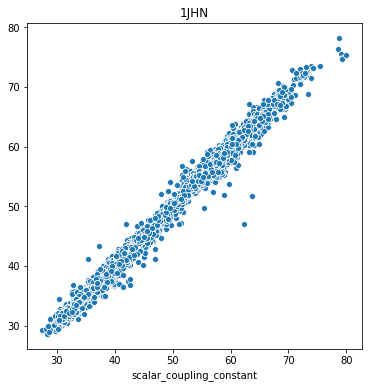

In [13]:
train_sample = train[train.type=='1JHN']
model_1JHN,_,_=SingleRun(train_sample,fc1,test_size=0.2,model_fn=XGBRegressor,includeType=False,early_stopping_rounds=5,
                max_depth=11, learning_rate=0.1, n_estimators=3000, 
                verbosity=1, 
                objective='reg:squarederror', booster='gbtree',tree_method= 'gpu_hist',
                n_jobs=4, 
                gamma=0, min_child_weight=1, max_delta_step=0, 
                subsample=1,colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, 
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
                random_state=0, seed=None, missing=None, importance_type='gain', eval_metric='mae')

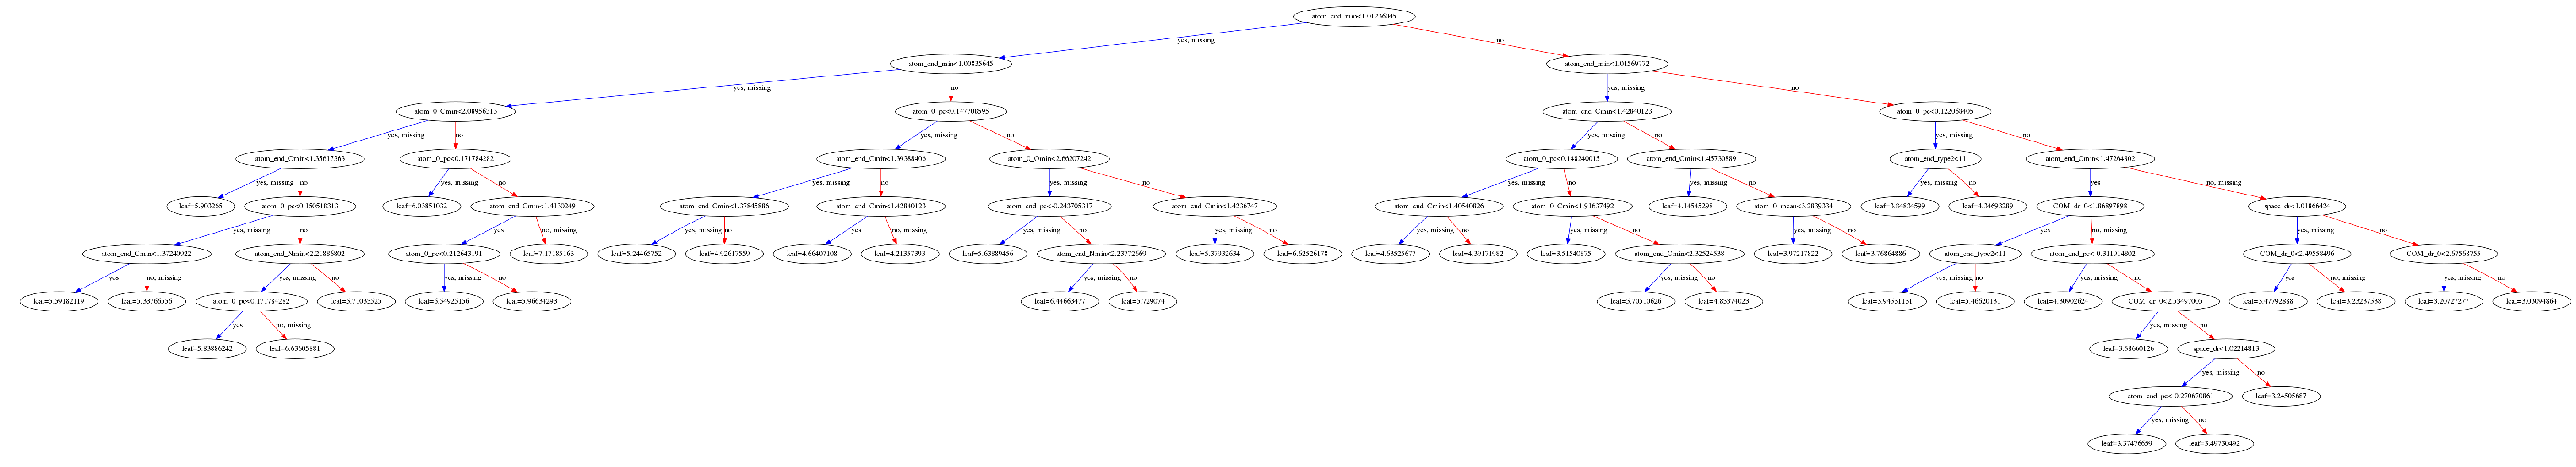

In [14]:
ax = xgboost.plot_tree(model_1JHN,num_trees=0)
fig = ax.figure
fig.set_size_inches(100,100)

/opt/conda/lib/python3.6/site-packages/xgboost/plotting.py:101: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xlim)


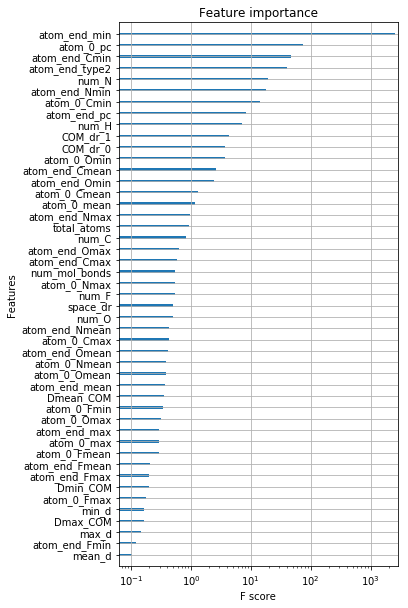

In [15]:
ax=xgboost.plot_importance(model_1JHN,importance_type='gain',show_values=False,log=True)
fig = ax.figure
fig.set_size_inches(5, 10)

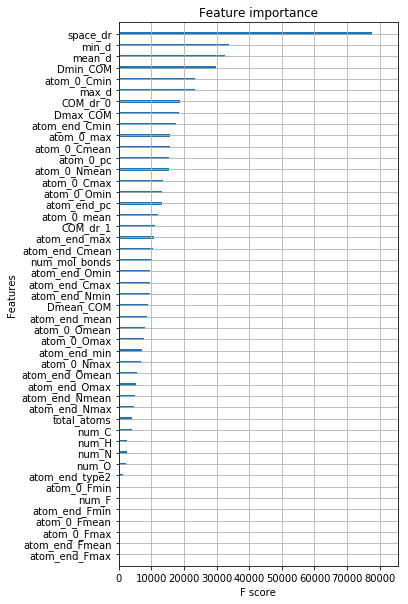

In [16]:
ax=xgboost.plot_importance(model_1JHN,importance_type='weight',show_values=False,log=False)
fig = ax.figure
fig.set_size_inches(5, 10)

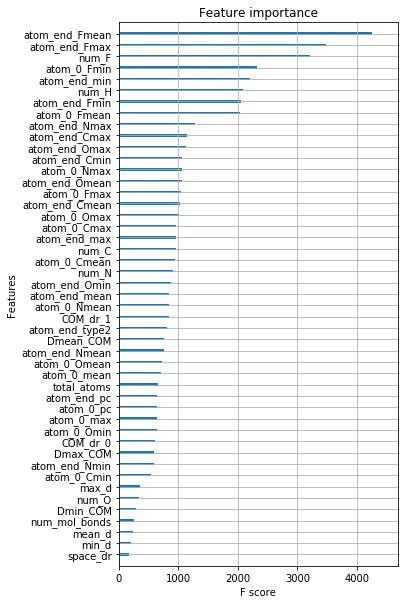

In [17]:
ax=xgboost.plot_importance(model_1JHN,importance_type='cover',show_values=False,log=False)
fig = ax.figure
fig.set_size_inches(5, 10)

In [18]:
def RunByType(df,test_size=0.25,model_fn=XGBRegressor,includeType=False,early_stopping_rounds=None,**kwargs):
    model_dict={}
    train_LMAE_dict={}
    val_LMAE_dict={}
    for coupling_type in coupling_types:
        print('Now training type:',str(coupling_type))

        df_type = df[df['type']==coupling_type]

        features=fc1.copy()
        if(coupling_type[0]=='2'):
            features.update(fc_2)
        elif(coupling_type[0]=='3'):
            features.update(fc_2[:-1]+fc_3)
        
        model,train_LMAE,val_LMAE = SingleRun(df_type,features,test_size,model_fn=model_fn,includeType=False,early_stopping_rounds=early_stopping_rounds,**kwargs)

        model_dict[coupling_type]=model
        train_LMAE_dict[coupling_type]=train_LMAE
        val_LMAE_dict[coupling_type]=val_LMAE
        
    train_LMAE = sum(train_LMAE_dict.values())/len(coupling_types)
    if test_size>0:
        val_LMAE = sum(val_LMAE_dict.values())/len(coupling_types)
    else:
        val_LMAE=None
    print('total train LMAE:',train_LMAE)
    print('total val LMAE', val_LMAE)
    gc.collect()
    return model_dict#,train_LMAE, val_LMAE

In [19]:
def PredictByType(df_X,model_dict,df_Y=None):
    predictions = pd.DataFrame()

    for coupling_type in coupling_types:
        print('predicting type:',str(coupling_type))
        model = model_dict[coupling_type]
        df_type = df_X[df_X['type']==coupling_type]
        
        features=fc1.copy()
        if(coupling_type[0]=='2'):
            features.update(fc_2)
        elif(coupling_type[0]=='3'):
            features.update(fc_2[:-1]+fc_3)
        
        predict = model.predict(df_type.loc[:,df_X.columns.map(lambda col: col in features)])
        predict = pd.Series(predict,index=df_type.index)
        predict = pd.DataFrame({'id':df_type.id,'scalar_coupling_constant': predict})
        predict.set_index('id',inplace=True)
        predictions = pd.concat([predictions,predict])
    
    if df_Y is not None:
        predictions.columns = ['predictions']
        merged = pd.merge(train,predictions,how='left',left_on='id',right_index=True)
        LMAE = CalcLMAE(df_Y, merged.predictions,merged.type)
        print('LMAE:', LMAE)
        g = sns.FacetGrid(merged,col="type", col_order = coupling_types,sharex=False,sharey=False)
        g.map(sns.scatterplot, "scalar_coupling_constant","predictions")
        del merged
    
    gc.collect()
    return predictions

Now training type: 1JHC


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


best LMAE: 0.0333844846862497
best ntree: 5961
training time: 449.0016407966614
	train LMAE: -4.332542135846674
	val LMAE: 0.03338500762107773
Now training type: 1JHN
best LMAE: -0.6543015377367472
best ntree: 887
training time: 37.329384326934814
	train LMAE: -5.6696469266919145
	val LMAE: -0.654300593208742
Now training type: 2JHC
best LMAE: -1.0057642283028978
best ntree: 6340
training time: 563.5398669242859
	train LMAE: -4.559749643243171
	val LMAE: -1.0057638877580637
Now training type: 2JHH
best LMAE: -1.3888055114202953
best ntree: 2259
training time: 157.42483711242676
	train LMAE: -4.708172830890961
	val LMAE: -1.3888047789660443
Now training type: 2JHN
best LMAE: -1.3330835064268232
best ntree: 1606
training time: 79.43266725540161
	train LMAE: -5.935377605529624
	val LMAE: -1.333083190436781
Now training type: 3JHC
best LMAE: -1.1455749736952137
best ntree: 7646
training time: 767.1035034656525
	train LMAE: -4.67273440094918
	val LMAE: -1.145574046729761
Now training type: 

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

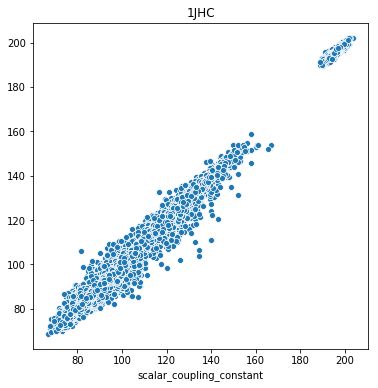

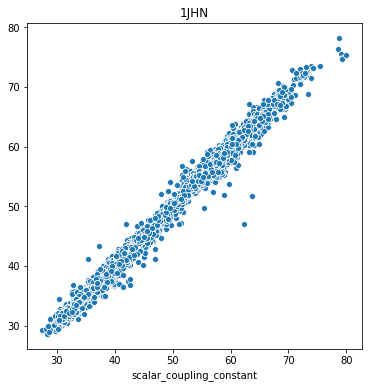

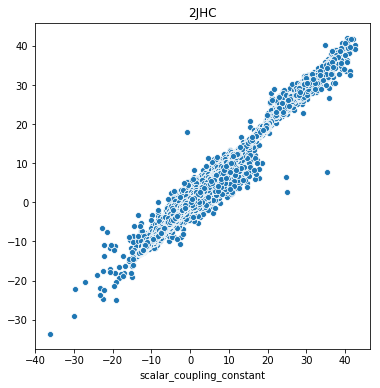

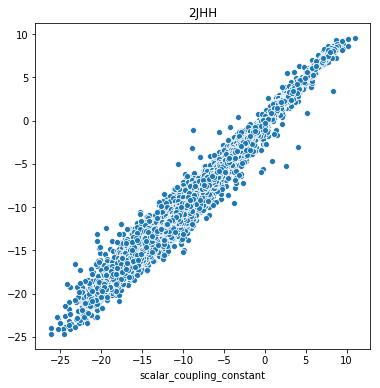

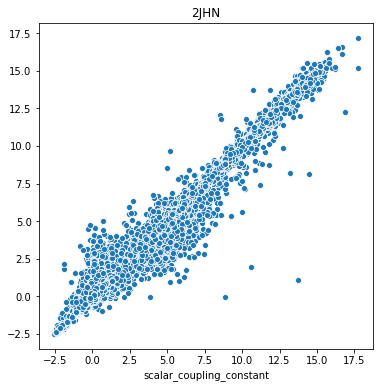

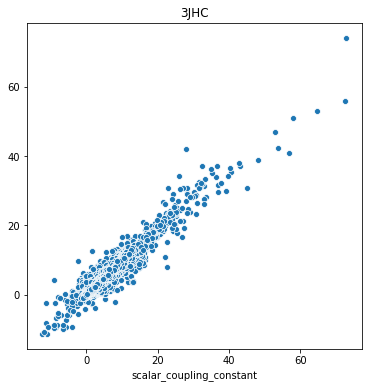

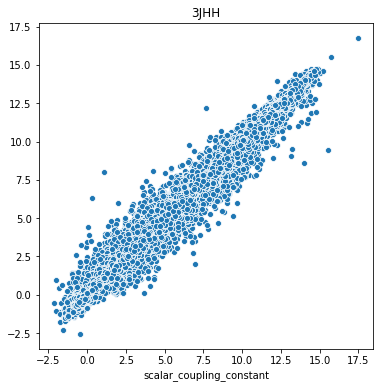

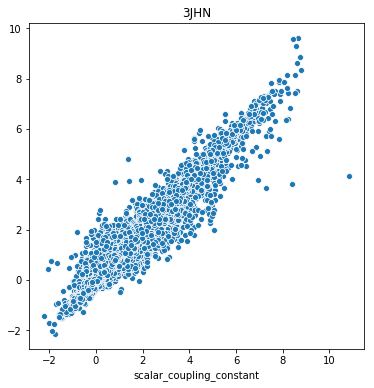

In [20]:
model_dict=RunByType(train,test_size=0.2,includeType=False,early_stopping_rounds=5,
                max_depth=11, learning_rate=0.1, n_estimators=10000, 
                verbosity=1, 
                objective='reg:squarederror', booster='gbtree',tree_method= 'gpu_hist',
                n_jobs=4, 
                gamma=0, min_child_weight=1, max_delta_step=0, 
                subsample=1,colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, 
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
                random_state=0, seed=None, missing=None, importance_type='gain', eval_metric='mae')

#train_predict = PredictByType(val_sample,model_dict,val_sample.scalar_coupling_constant)
test_predict = PredictByType(test,model_dict)
test_predict.to_csv('test_predict_TypeModel.csv')

In [21]:
print('FINISHED!')

FINISHED!
